# Feature Engineering with Sklearn

## What is Feature Engineering?

**Definition**: Creating new features from existing data to improve model performance

**Why Important?**
> "Applied machine learning is basically feature engineering" - Andrew Ng

Good features can:
- Improve model accuracy
- Reduce training time
- Make models more interpretable

## Topics Covered

1. **Polynomial Features**: Create interaction terms and powers
2. **Binning/Discretization**: Convert continuous → categorical
3. **Date/Time Features**: Extract useful components from dates
4. **Custom Transformations**: Domain-specific features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta

np.random.seed(42)

## 1. Polynomial Features

**Definition**: Creates polynomial and interaction features from original features

**Example**: For features [a, b]
- Degree 1: [1, a, b]
- Degree 2: [1, a, b, a², ab, b²]
- Degree 3: [1, a, b, a², ab, b², a³, a²b, ab², b³]

**Why Use?**
- Capture non-linear relationships
- Model interactions between features
- Make linear models more powerful

**Example Use Case**: 
- House price = area × price_per_sqft (interaction)
- Profit might depend on price² (non-linear)

In [2]:
# Simple example: 2 features
X = np.array([
    [2, 3],
    [4, 5]
])

print("Original Features:")
print("[a, b]")
print(X)

# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly.fit_transform(X)

print("\nPolynomial Features (degree=2):")
print("Feature names:", poly.get_feature_names_out(['a', 'b']))
print(X_poly)

# Verify calculations for first row [2, 3]
print("\nVerification for [2, 3]:")
print(f"  1:      {1}")
print(f"  a:      {2}")
print(f"  b:      {3}")
print(f"  a²:     {2**2}")
print(f"  a×b:    {2*3}")
print(f"  b²:     {3**2}")

Original Features:
[a, b]
[[2 3]
 [4 5]]

Polynomial Features (degree=2):
Feature names: ['1' 'a' 'b' 'a^2' 'a b' 'b^2']
[[ 1.  2.  3.  4.  6.  9.]
 [ 1.  4.  5. 16. 20. 25.]]

Verification for [2, 3]:
  1:      1
  a:      2
  b:      3
  a²:     4
  a×b:    6
  b²:     9


In [3]:
# Different parameters
X_sample = np.array([[2, 3]])

print("="*60)
print("POLYNOMIAL FEATURES - DIFFERENT CONFIGURATIONS")
print("="*60)

# Degree 3
poly_d3 = PolynomialFeatures(degree=3, include_bias=False)
X_d3 = poly_d3.fit_transform(X_sample)
print("\nDegree=3, include_bias=False:")
print(f"Features ({X_d3.shape[1]}): {poly_d3.get_feature_names_out(['a', 'b'])}")
print(X_d3)

# Only interaction features (no powers)
poly_interact = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interact = poly_interact.fit_transform(X_sample)
print("\nDegree=2, interaction_only=True:")
print(f"Features ({X_interact.shape[1]}): {poly_interact.get_feature_names_out(['a', 'b'])}")
print(X_interact)
print("(Only a, b, a×b - no a², b²)")

POLYNOMIAL FEATURES - DIFFERENT CONFIGURATIONS

Degree=3, include_bias=False:
Features (9): ['a' 'b' 'a^2' 'a b' 'b^2' 'a^3' 'a^2 b' 'a b^2' 'b^3']
[[ 2.  3.  4.  6.  9.  8. 12. 18. 27.]]

Degree=2, interaction_only=True:
Features (3): ['a' 'b' 'a b']
[[2. 3. 6.]]
(Only a, b, a×b - no a², b²)


### Polynomial Regression Example

Fit non-linear data using polynomial features:

Dataset: y = 0.5*x² + x + 2 + noise
Training samples: 80
Test samples: 20

Degree 1:
  Features: 1
  Train R²: 0.9300
  Test R²:  0.9309

Degree 2:
  Features: 2
  Train R²: 0.9775
  Test R²:  0.9802

Degree 3:
  Features: 3
  Train R²: 0.9786
  Test R²:  0.9808

Degree 5:
  Features: 5
  Train R²: 0.9791
  Test R²:  0.9793


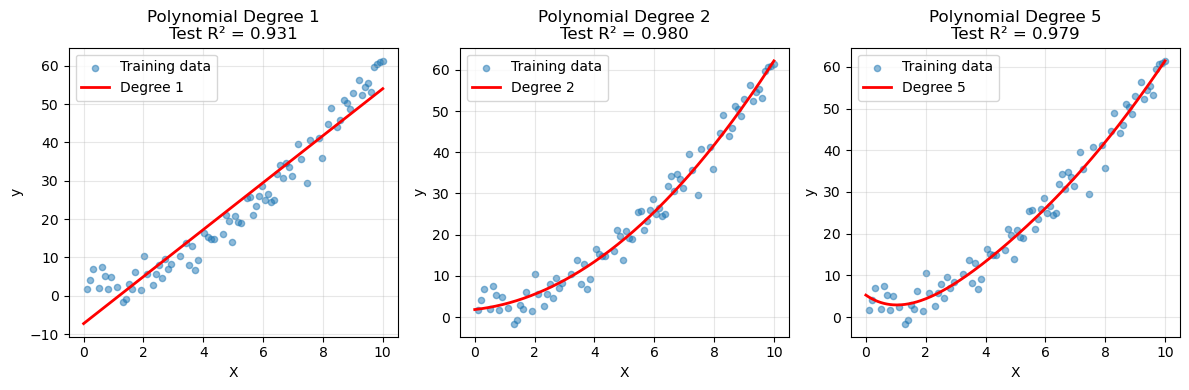


💡 Observation:
  - Degree 1 (linear): Underfitting
  - Degree 2: Good fit (matches true relationship)
  - Degree 5: Might overfit (too flexible)


In [4]:
# Generate non-linear data
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = 0.5 * X**2 + X + 2 + np.random.randn(100, 1) * 3

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dataset: y = 0.5*x² + x + 2 + noise")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# Compare: Linear vs Polynomial Regression
results = {}

for degree in [1, 2, 3, 5]:
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Train linear regression on polynomial features
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Evaluate
    train_score = model.score(X_train_poly, y_train)
    test_score = model.score(X_test_poly, y_test)
    
    results[degree] = {'train_r2': train_score, 'test_r2': test_score}
    
    print(f"\nDegree {degree}:")
    print(f"  Features: {X_train_poly.shape[1]}")
    print(f"  Train R²: {train_score:.4f}")
    print(f"  Test R²:  {test_score:.4f}")

# Plot results
plt.figure(figsize=(12, 4))

for i, degree in enumerate([1, 2, 5]):
    plt.subplot(1, 3, i+1)
    
    # Transform data
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Plot
    X_plot = np.linspace(0, 10, 300).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = model.predict(X_plot_poly)
    
    plt.scatter(X_train, y_train, alpha=0.5, s=20, label='Training data')
    plt.plot(X_plot, y_plot, 'r-', linewidth=2, label=f'Degree {degree}')
    plt.title(f'Polynomial Degree {degree}\nTest R² = {results[degree]["test_r2"]:.3f}')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Observation:")
print("  - Degree 1 (linear): Underfitting")
print("  - Degree 2: Good fit (matches true relationship)")
print("  - Degree 5: Might overfit (too flexible)")

## 2. Binning / Discretization

**Definition**: Convert continuous values into discrete bins/categories

**Example**: Age → Age Groups
- Age 25 → '18-30'
- Age 45 → '31-50'
- Age 65 → '51+'

**Why Use?**
- Reduce noise from continuous features
- Handle non-linear relationships
- Make models more robust
- Create interpretable categories

## Binning Strategies

| Strategy | Description | When to Use |
|----------|-------------|-------------|
| **uniform** | Equal-width bins | Data is uniformly distributed |
| **quantile** | Equal-frequency bins | Data is skewed |
| **kmeans** | Cluster-based bins | Complex distributions |

In [5]:
# Sample data: ages
ages = np.array([18, 22, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]).reshape(-1, 1)

print("Original Ages:")
print(ages.flatten())

# Strategy 1: Uniform (equal-width bins)
binner_uniform = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
ages_uniform = binner_uniform.fit_transform(ages)

print("\nUniform Binning (4 bins):")
print("Bin edges:", binner_uniform.bin_edges_[0])
print("Binned:", ages_uniform.flatten())

# Strategy 2: Quantile (equal-frequency bins)
binner_quantile = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
ages_quantile = binner_quantile.fit_transform(ages)

print("\nQuantile Binning (4 bins):")
print("Bin edges:", binner_quantile.bin_edges_[0])
print("Binned:", ages_quantile.flatten())

# Create comparison dataframe
comparison = pd.DataFrame({
    'Age': ages.flatten(),
    'Uniform_Bin': ages_uniform.flatten().astype(int),
    'Quantile_Bin': ages_quantile.flatten().astype(int)
})

print("\nComparison:")
print(comparison)

Original Ages:
[18 22 25 30 35 40 45 50 55 60 65 70 75 80]

Uniform Binning (4 bins):
Bin edges: [18.  33.5 49.  64.5 80. ]
Binned: [0. 0. 0. 0. 1. 1. 1. 2. 2. 2. 3. 3. 3. 3.]

Quantile Binning (4 bins):
Bin edges: [18.   31.25 47.5  63.75 80.  ]
Binned: [0. 0. 0. 0. 1. 1. 1. 2. 2. 2. 3. 3. 3. 3.]

Comparison:
    Age  Uniform_Bin  Quantile_Bin
0    18            0             0
1    22            0             0
2    25            0             0
3    30            0             0
4    35            1             1
5    40            1             1
6    45            1             1
7    50            2             2
8    55            2             2
9    60            2             2
10   65            3             3
11   70            3             3
12   75            3             3
13   80            3             3


In [6]:
# Different encoding options
print("="*60)
print("BINNING ENCODING OPTIONS")
print("="*60)

sample_ages = np.array([22, 35, 48, 61]).reshape(-1, 1)
print(f"\nSample ages: {sample_ages.flatten()}")

# encode='ordinal' - Bin number
binner_ord = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
binned_ord = binner_ord.fit_transform(sample_ages)
print("\nencode='ordinal':")
print(f"Result: {binned_ord.flatten()}")
print("Meaning: Which bin (0, 1, 2)")

# encode='onehot' - Binary columns
binner_ohe = KBinsDiscretizer(n_bins=3, encode='onehot', strategy='uniform')
binned_ohe = binner_ohe.fit_transform(sample_ages).toarray()
print("\nencode='onehot':")
print(binned_ohe)
print("Meaning: One-hot encoded bins")

# encode='onehot-dense' - Same as onehot but dense array
binner_dense = KBinsDiscretizer(n_bins=3, encode='onehot-dense', strategy='uniform')
binned_dense = binner_dense.fit_transform(sample_ages)
print("\nencode='onehot-dense':")
print(binned_dense)

BINNING ENCODING OPTIONS

Sample ages: [22 35 48 61]

encode='ordinal':
Result: [0. 1. 2. 2.]
Meaning: Which bin (0, 1, 2)

encode='onehot':
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
Meaning: One-hot encoded bins

encode='onehot-dense':
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


### Pandas Alternative: pd.cut() and pd.qcut()

For quick exploratory analysis:

In [7]:
# Sample salary data
salaries = pd.Series([25000, 35000, 45000, 55000, 65000, 75000, 85000, 95000, 120000, 150000])

print("Original Salaries:")
print(salaries.values)

# pd.cut - Fixed bin edges
bins_cut = pd.cut(salaries, bins=3, labels=['Low', 'Medium', 'High'])
print("\npd.cut (equal-width):")
print(bins_cut)

# pd.qcut - Quantile-based
bins_qcut = pd.qcut(salaries, q=3, labels=['Low', 'Medium', 'High'])
print("\npd.qcut (equal-frequency):")
print(bins_qcut)

# Custom bin edges
bins_custom = pd.cut(
    salaries, 
    bins=[0, 50000, 80000, 200000],
    labels=['Junior', 'Mid-level', 'Senior']
)
print("\nCustom bins:")
print(bins_custom)

# Value counts
print("\nDistribution:")
print(bins_custom.value_counts())

Original Salaries:
[ 25000  35000  45000  55000  65000  75000  85000  95000 120000 150000]

pd.cut (equal-width):
0       Low
1       Low
2       Low
3       Low
4       Low
5    Medium
6    Medium
7    Medium
8      High
9      High
dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

pd.qcut (equal-frequency):
0       Low
1       Low
2       Low
3    Medium
4    Medium
5    Medium
6      High
7      High
8      High
9      High
dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

Custom bins:
0       Junior
1       Junior
2       Junior
3    Mid-level
4    Mid-level
5    Mid-level
6       Senior
7       Senior
8       Senior
9       Senior
dtype: category
Categories (3, object): ['Junior' < 'Mid-level' < 'Senior']

Distribution:
Senior       4
Junior       3
Mid-level    3
Name: count, dtype: int64


## 3. Date/Time Feature Engineering

**Problem**: Dates are often stored as strings or timestamps

**Solution**: Extract meaningful temporal features

**Common Date Features**:
- Year, Month, Day
- Day of week (Monday=0, Sunday=6)
- Is weekend?
- Quarter (Q1, Q2, Q3, Q4)
- Is month start/end?
- Days since/until event
- Hour, Minute (for timestamps)
- Is holiday?

**Why Important?**
- Capture seasonality
- Detect patterns (e.g., higher sales on weekends)
- Time-based trends

In [8]:
# Create sample date data
dates = pd.date_range(start='2025-01-01', end='2025-12-31', freq='7D')
df_dates = pd.DataFrame({'date': dates})

print("Original Dates:")
print(df_dates.head(10))
print(f"\nTotal dates: {len(df_dates)}")

# Extract date features
df_dates['year'] = df_dates['date'].dt.year
df_dates['month'] = df_dates['date'].dt.month
df_dates['day'] = df_dates['date'].dt.day
df_dates['day_of_week'] = df_dates['date'].dt.dayofweek  # Monday=0, Sunday=6
df_dates['day_name'] = df_dates['date'].dt.day_name()
df_dates['week_of_year'] = df_dates['date'].dt.isocalendar().week
df_dates['quarter'] = df_dates['date'].dt.quarter
df_dates['is_weekend'] = df_dates['day_of_week'].isin([5, 6]).astype(int)
df_dates['is_month_start'] = df_dates['date'].dt.is_month_start.astype(int)
df_dates['is_month_end'] = df_dates['date'].dt.is_month_end.astype(int)

print("\nExtracted Features:")
print(df_dates.head(10))

print("\nFeature Statistics:")
print(f"Unique months: {df_dates['month'].nunique()}")
print(f"Weekend dates: {df_dates['is_weekend'].sum()}")
print(f"Weekday dates: {(1-df_dates['is_weekend']).sum()}")

Original Dates:
        date
0 2025-01-01
1 2025-01-08
2 2025-01-15
3 2025-01-22
4 2025-01-29
5 2025-02-05
6 2025-02-12
7 2025-02-19
8 2025-02-26
9 2025-03-05

Total dates: 53

Extracted Features:
        date  year  month  day  day_of_week   day_name  week_of_year  quarter  \
0 2025-01-01  2025      1    1            2  Wednesday             1        1   
1 2025-01-08  2025      1    8            2  Wednesday             2        1   
2 2025-01-15  2025      1   15            2  Wednesday             3        1   
3 2025-01-22  2025      1   22            2  Wednesday             4        1   
4 2025-01-29  2025      1   29            2  Wednesday             5        1   
5 2025-02-05  2025      2    5            2  Wednesday             6        1   
6 2025-02-12  2025      2   12            2  Wednesday             7        1   
7 2025-02-19  2025      2   19            2  Wednesday             8        1   
8 2025-02-26  2025      2   26            2  Wednesday             9      

In [9]:
# Advanced date features
print("="*60)
print("ADVANCED DATE FEATURES")
print("="*60)

# Days since reference date
reference_date = pd.Timestamp('2025-01-01')
df_dates['days_since_start'] = (df_dates['date'] - reference_date).dt.days

# Days until end of year
end_of_year = pd.Timestamp('2025-12-31')
df_dates['days_until_end'] = (end_of_year - df_dates['date']).dt.days

# Cyclical encoding for month (preserves circular nature)
df_dates['month_sin'] = np.sin(2 * np.pi * df_dates['month'] / 12)
df_dates['month_cos'] = np.cos(2 * np.pi * df_dates['month'] / 12)

# Cyclical encoding for day of week
df_dates['dow_sin'] = np.sin(2 * np.pi * df_dates['day_of_week'] / 7)
df_dates['dow_cos'] = np.cos(2 * np.pi * df_dates['day_of_week'] / 7)

print("\nAdvanced Features:")
print(df_dates[[
    'date', 'days_since_start', 'days_until_end', 
    'month_sin', 'month_cos', 'dow_sin', 'dow_cos'
]].head(10))

print("\n💡 Why Cyclical Encoding?")
print("  - December (12) and January (1) are close in time")
print("  - Standard encoding: |12 - 1| = 11 (far apart)")
print("  - Cyclical encoding: Captures circular relationship")

ADVANCED DATE FEATURES

Advanced Features:
        date  days_since_start  days_until_end  month_sin     month_cos  \
0 2025-01-01                 0             364   0.500000  8.660254e-01   
1 2025-01-08                 7             357   0.500000  8.660254e-01   
2 2025-01-15                14             350   0.500000  8.660254e-01   
3 2025-01-22                21             343   0.500000  8.660254e-01   
4 2025-01-29                28             336   0.500000  8.660254e-01   
5 2025-02-05                35             329   0.866025  5.000000e-01   
6 2025-02-12                42             322   0.866025  5.000000e-01   
7 2025-02-19                49             315   0.866025  5.000000e-01   
8 2025-02-26                56             308   0.866025  5.000000e-01   
9 2025-03-05                63             301   1.000000  6.123234e-17   

    dow_sin   dow_cos  
0  0.974928 -0.222521  
1  0.974928 -0.222521  
2  0.974928 -0.222521  
3  0.974928 -0.222521  
4  0.974928

### Real Example: Predicting Sales with Date Features

In [10]:
# Generate synthetic sales data
np.random.seed(42)
dates = pd.date_range(start='2024-01-01', end='2025-12-31', freq='D')
n_days = len(dates)

# Create sales with patterns
sales = (
    100 +  # Base sales
    30 * np.sin(2 * np.pi * np.arange(n_days) / 365) +  # Yearly seasonality
    20 * np.sin(2 * np.pi * np.arange(n_days) / 7) +    # Weekly pattern
    np.random.randn(n_days) * 10  # Noise
)

# Add weekend boost
day_of_week = pd.to_datetime(dates).dayofweek
weekend_boost = np.where(day_of_week.isin([5, 6]), 25, 0)
sales = sales + weekend_boost

# Create dataframe
df_sales = pd.DataFrame({'date': dates, 'sales': sales})

print("Sales Data Sample:")
print(df_sales.head(10))
print(f"\nDate range: {df_sales['date'].min()} to {df_sales['date'].max()}")
print(f"Average sales: ${df_sales['sales'].mean():.2f}")

# Extract features
df_sales['day_of_week'] = df_sales['date'].dt.dayofweek
df_sales['month'] = df_sales['date'].dt.month
df_sales['quarter'] = df_sales['date'].dt.quarter
df_sales['is_weekend'] = df_sales['day_of_week'].isin([5, 6]).astype(int)
df_sales['day_of_year'] = df_sales['date'].dt.dayofyear

# Cyclical features
df_sales['dow_sin'] = np.sin(2 * np.pi * df_sales['day_of_week'] / 7)
df_sales['dow_cos'] = np.cos(2 * np.pi * df_sales['day_of_week'] / 7)
df_sales['month_sin'] = np.sin(2 * np.pi * df_sales['month'] / 12)
df_sales['month_cos'] = np.cos(2 * np.pi * df_sales['month'] / 12)

# Prepare for modeling
feature_cols = ['day_of_week', 'month', 'quarter', 'is_weekend', 
                'day_of_year', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']
X = df_sales[feature_cols]
y = df_sales['sales']

# Train-test split (last 3 months for testing)
split_date = '2025-10-01'
train_mask = df_sales['date'] < split_date
test_mask = df_sales['date'] >= split_date

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("\n" + "="*60)
print("MODEL PERFORMANCE")
print("="*60)
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²:  {test_r2:.4f}")
print(f"Test RMSE: ${test_rmse:.2f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("\nFeature Importance (by coefficient magnitude):")
print(feature_importance)

Sales Data Sample:
        date       sales
0 2024-01-01  104.967142
1 2024-01-02  114.770387
2 2024-01-03  127.008092
3 2024-01-04  125.456563
4 2024-01-05   91.044864
5 2024-01-06  105.739016
6 2024-01-07  128.248549
7 2024-01-08  111.280589
8 2024-01-09  115.060249
9 2024-01-10  129.553423

Date range: 2024-01-01 00:00:00 to 2025-12-31 00:00:00
Average sales: $107.02

Training samples: 639
Test samples: 92

MODEL PERFORMANCE
Train R²: 0.8257
Test R²:  0.5329
Test RMSE: $10.87

Feature Importance (by coefficient magnitude):
       feature  coefficient
7    month_sin    28.119948
3   is_weekend    27.288147
5      dow_sin    19.966984
8    month_cos    -7.507342
2      quarter     1.326056
1        month     0.710068
0  day_of_week    -0.530257
6      dow_cos    -0.373580
4  day_of_year    -0.036123


## 4. Custom Transformations

**Definition**: Create domain-specific features using FunctionTransformer

**Use Cases**:
- Log transformation: `log(x)` for right-skewed data
- Square root: `√x` for count data
- Reciprocal: `1/x` for rates
- Domain formulas: BMI = weight / height²

In [11]:
# Example: House price features
house_data = pd.DataFrame({
    'area_sqft': [1000, 1500, 2000, 2500, 3000],
    'price': [200000, 280000, 350000, 420000, 480000],
    'bedrooms': [2, 3, 3, 4, 4],
    'age_years': [5, 10, 15, 20, 25]
})

print("Original Data:")
print(house_data)

# Create custom features
house_data['price_per_sqft'] = house_data['price'] / house_data['area_sqft']
house_data['sqft_per_bedroom'] = house_data['area_sqft'] / house_data['bedrooms']
house_data['log_price'] = np.log(house_data['price'])
house_data['age_squared'] = house_data['age_years'] ** 2

print("\nWith Engineered Features:")
print(house_data)

# Using FunctionTransformer
print("\n" + "="*60)
print("USING FunctionTransformer")
print("="*60)

# Log transformer
log_transformer = FunctionTransformer(np.log1p, validate=True)  # log1p = log(1+x)
prices = house_data[['price']].values
prices_log = log_transformer.fit_transform(prices)

print("\nLog transformation:")
print(f"Original: {prices.flatten()}")
print(f"Log(1+x): {prices_log.flatten()}")

# Square root transformer
sqrt_transformer = FunctionTransformer(np.sqrt, validate=True)
area = house_data[['area_sqft']].values
area_sqrt = sqrt_transformer.fit_transform(area)

print("\nSquare root transformation:")
print(f"Original: {area.flatten()}")
print(f"Sqrt:     {area_sqrt.flatten()}")

# Custom function
def price_category(X):
    """Categorize price: 0=low, 1=medium, 2=high"""
    return np.select(
        [X < 250000, X < 400000],
        [0, 1],
        default=2
    ).reshape(-1, 1)

category_transformer = FunctionTransformer(price_category, validate=True)
price_categories = category_transformer.fit_transform(prices)

print("\nCustom categorization:")
print(f"Prices:     {prices.flatten()}")
print(f"Categories: {price_categories.flatten()}")
print("  0 = Low (<$250k), 1 = Medium (<$400k), 2 = High")

Original Data:
   area_sqft   price  bedrooms  age_years
0       1000  200000         2          5
1       1500  280000         3         10
2       2000  350000         3         15
3       2500  420000         4         20
4       3000  480000         4         25

With Engineered Features:
   area_sqft   price  bedrooms  age_years  price_per_sqft  sqft_per_bedroom  \
0       1000  200000         2          5      200.000000        500.000000   
1       1500  280000         3         10      186.666667        500.000000   
2       2000  350000         3         15      175.000000        666.666667   
3       2500  420000         4         20      168.000000        625.000000   
4       3000  480000         4         25      160.000000        750.000000   

   log_price  age_squared  
0  12.206073           25  
1  12.542545          100  
2  12.765688          225  
3  12.948010          400  
4  13.081541          625  

USING FunctionTransformer

Log transformation:
Original: [2000

## 5. Feature Interactions

**Definition**: Combining features to capture relationships

**Examples**:
- BMI = weight / height²
- Debt-to-Income Ratio = debt / income
- Price per unit = total_price / quantity

In [12]:
# Example: Customer analytics
customer_data = pd.DataFrame({
    'total_purchases': [10, 25, 50, 100, 5],
    'total_spent': [500, 1200, 2500, 5000, 200],
    'days_active': [30, 90, 180, 365, 15],
    'returns': [1, 2, 3, 5, 1]
})

print("Original Customer Data:")
print(customer_data)

# Create interaction features
customer_data['avg_purchase_value'] = (
    customer_data['total_spent'] / customer_data['total_purchases']
)
customer_data['purchases_per_day'] = (
    customer_data['total_purchases'] / customer_data['days_active']
)
customer_data['return_rate'] = (
    customer_data['returns'] / customer_data['total_purchases']
)
customer_data['spending_per_day'] = (
    customer_data['total_spent'] / customer_data['days_active']
)

print("\nWith Interaction Features:")
print(customer_data.round(2))

print("\n💡 These features reveal:")
print("  - avg_purchase_value: Customer spending power")
print("  - purchases_per_day: Engagement level")
print("  - return_rate: Product satisfaction")
print("  - spending_per_day: Revenue potential")

Original Customer Data:
   total_purchases  total_spent  days_active  returns
0               10          500           30        1
1               25         1200           90        2
2               50         2500          180        3
3              100         5000          365        5
4                5          200           15        1

With Interaction Features:
   total_purchases  total_spent  days_active  returns  avg_purchase_value  \
0               10          500           30        1                50.0   
1               25         1200           90        2                48.0   
2               50         2500          180        3                50.0   
3              100         5000          365        5                50.0   
4                5          200           15        1                40.0   

   purchases_per_day  return_rate  spending_per_day  
0               0.33         0.10             16.67  
1               0.28         0.08             13.33  

## Feature Engineering Best Practices

### 1. Domain Knowledge
- Understand your data and business context
- Talk to domain experts
- Research common features in your field

### 2. Iterative Process
```
1. Create features
2. Train model
3. Check feature importance
4. Remove useless features
5. Create new features
6. Repeat
```

### 3. Avoid Data Leakage
❌ Don't use future information  
❌ Don't use target-derived features  
✅ Only use past/current information  

### 4. Feature Scaling
After creating features, remember to scale!

### 5. Feature Selection
More features ≠ Better model
- Remove highly correlated features
- Use feature importance
- Try feature selection methods

## Quick Reference

```python
# Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Binning
from sklearn.preprocessing import KBinsDiscretizer
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
X_binned = binner.fit_transform(X)

# Date Features (Pandas)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6])

# Custom Transformation
from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log1p)
X_log = log_transformer.fit_transform(X)
```

## Key Takeaways

1. **Polynomial Features**: Capture non-linearity and interactions
2. **Binning**: Convert continuous to categorical, reduce noise
3. **Date Features**: Extract temporal patterns (day, month, weekend, etc.)
4. **Cyclical Encoding**: Use sin/cos for circular features (months, days)
5. **Custom Features**: Create domain-specific features
6. **Interactions**: Combine features to reveal relationships
7. **Always validate**: Check if engineered features improve performance